In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import scipy.stats as st
import seaborn as sns

from matplotlib.lines import Line2D
from tqdm import tqdm
from datetime import timedelta, datetime
from sklearn.decomposition import NMF

In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100.head()

Unnamed: 0 first_day_of_the_week                            artist  \
0        1611            1959-01-12  The Chipmunks With David Seville   
1        1615            1959-01-05  The Chipmunks With David Seville   
2        1628            1959-01-12                      The Platters   
3        1629            1959-01-12                    Connie Francis   
4        1630            1959-01-12                     Billy Grammer   

                 song_name  position  last_week_position  peak_position  \
0        The Chipmunk Song         1                 1.0              1   
1        The Chipmunk Song         1                 1.0              1   
2  Smoke Gets In Your Eyes         2                 2.0              2   
3             My Happiness         3                 6.0              3   
4          Gotta Travel On         4                 9.0              4   

   weeks_on_chart  year  
0               7  1959  
1               6  1959  
2               9  1959  
3               6  1959  
4               8  1959

In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["top_position"] = billboard_hot_100.groupby("artist_song")["position"].transform("min")

In [6]:
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, 'valid')

In [7]:
decades_data = {}

## Rank turnover

In [8]:
# number of songs ever seen until time t
def number_of_songs_seen(df, t):
    return len(df[df["first_day_of_the_week"] <= t]["artist_song"].unique())/100

In [9]:
number_of_songs_ever_seen = []

for decade in tqdm(range(1960, 2020, 10)):
    number_of_songs_ever_seen = []
    decades_data[decade] = {}
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    for l, first_day_of_the_week in tqdm(enumerate(songs_from_decade["first_day_of_the_week"].sort_values().unique())):
        number_of_songs_ever_seen.append(number_of_songs_seen(songs_from_decade, first_day_of_the_week))

    T_size = len(songs_from_decade["first_day_of_the_week"].sort_values().unique())
    mean_turnover = (number_of_songs_ever_seen[len(number_of_songs_ever_seen) - 1] - number_of_songs_ever_seen[0]) / (T_size - 1)
    decades_data[decade]["o"] = mean_turnover
    print(f"Mean turnover rate for {decade}s: " + str(mean_turnover))

522it [00:03, 140.41it/s]00<?, ?it/s]
 17%|█▋        | 1/6 [00:03<00:18,  3.77s/it]

Mean turnover rate for 1960s: 0.13174664107485604


522it [00:03, 140.73it/s]
 33%|███▎      | 2/6 [00:07<00:14,  3.75s/it]

Mean turnover rate for 1970s: 0.10166986564299424


521it [00:03, 152.04it/s]
 50%|█████     | 3/6 [00:10<00:10,  3.61s/it]

Mean turnover rate for 1980s: 0.07911538461538462


522it [00:03, 150.61it/s]
 67%|██████▋   | 4/6 [00:14<00:07,  3.56s/it]

Mean turnover rate for 1990s: 0.06587332053742802


522it [00:03, 149.60it/s]
 83%|████████▎ | 5/6 [00:17<00:03,  3.54s/it]

Mean turnover rate for 2000s: 0.06562380038387715


522it [00:03, 133.68it/s]
100%|██████████| 6/6 [00:21<00:00,  3.65s/it]

Mean turnover rate for 2010s: 0.08591170825335892


## Rank flux

In [10]:
# probabilities that song enter or leaves the chart at time t
def song_enter_leave_probabilities(df, t):
    songs_previous_week = df[df["first_day_of_the_week"] == (pd.to_datetime(t) - timedelta(weeks=1))]["artist_song"].unique()
    songs_now = df[df["first_day_of_the_week"] == t]["artist_song"].unique()
    songs_entered = list(set(songs_now) - set(songs_previous_week))
    return len(songs_entered)/100

In [11]:
enter_leave_porbabilities = []
for decade in tqdm(range(1960, 2020, 10)):
    enter_leave_porbabilities = []
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    for first_day_of_the_week in tqdm(songs_from_decade["first_day_of_the_week"].sort_values().unique()):
        enter_leave_porbabilities.append(song_enter_leave_probabilities(songs_from_decade, first_day_of_the_week))

    mean_flux = np.mean(enter_leave_porbabilities)
    decades_data[decade]["F"] = mean_flux
    print(f"Mean flux for {decade}s: " + str(mean_flux))

 17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]

Mean flux for 1960s: 0.14028735632183906


 33%|███▎      | 2/6 [00:01<00:03,  1.14it/s]

Mean flux for 1970s: 0.10549808429118776


 50%|█████     | 3/6 [00:02<00:02,  1.05it/s]

Mean flux for 1980s: 0.08140115163147793


 67%|██████▋   | 4/6 [00:03<00:02,  1.01s/it]

Mean flux for 1990s: 0.06909961685823757


 83%|████████▎ | 5/6 [00:04<00:00,  1.05it/s]

Mean flux for 2000s: 0.07563218390804599


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

Mean flux for 2010s: 0.10942528735632184


In [12]:
for decade in tqdm(range(1960, 2020, 10)):
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    p0 = 100 / songs_from_decade["artist_song"].nunique()
    decades_data[decade]["p0"] = p0
    print(f"p0 for {decade}s: " + str(100 / songs_from_decade["artist_song"].nunique()))

100%|██████████| 6/6 [00:00<00:00, 44.24it/s]

p0 for 1960s: 0.014359563469270534
p0 for 1970s: 0.01852881230313137
p0 for 1980s: 0.023730422401518746
p0 for 1990s: 0.028312570781426953
p0 for 2000s: 0.02841716396703609
p0 for 2010s: 0.021853146853146852


## Displacement probability

In [13]:
import pickle

# with open('displacement_prob_data.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [14]:
with open('displacement_prob_data.pkl', 'rb') as f:
    data = pickle.load(f)

### t=1

In [15]:
def probability(df, initial_rank, new_pos, t):
    init_rank_df = df[(pd.to_datetime(t) + timedelta(weeks=-1)).to_datetime64()][initial_rank]
    time_after_df = df[t][new_pos]
    new_pos_after_t = set(init_rank_df).intersection(set(time_after_df))
    return len(new_pos_after_t) / len(init_rank_df)

In [16]:
decades_data[1960]["v"] = 0.0114
decades_data[1970]["v"] = 0.0076
decades_data[1980]["v"] = 0.0054
decades_data[1990]["v"] = 0.0046
decades_data[2000]["v"] = 0.005
decades_data[2010]["v"] = 0.0098

for decade in tqdm(range(1960, 2020, 10)):
    decades_data[decade]["tau"] = decades_data[decade]["v"] * (decades_data[decade]["o"] - decades_data[decade]["v"]) / (decades_data[decade]["v"] - decades_data[decade]["p0"] * decades_data[decade]["o"])


100%|██████████| 6/6 [00:00<?, ?it/s]


In [23]:
import math
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0
N0 = 100

#model
for decade in tqdm(range(1960, 2020, 10)):
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    tau = decades_data[decade]["tau"]
    v = decades_data[decade]["v"]
    N = songs_from_decade["artist_song"].nunique()
    p0 = N0 / N
    initial_ranks = [20, 40, 60, 80]
    pxts = []
    dr = 1/N

    colors = ["royalblue", "dodgerblue", "lightblue", "wheat", "sandybrown", "chocolate"]

    for i, initial_rank in enumerate(initial_ranks):
        #https://github.com/iniguezg/Farranks/tree/9b661fb269b52a381bc47662d0f573bbdafe011c
        r = (initial_rank) * dr
        ptau, pnu = tau, v

        dr = 1 / float( N ) #rank increment
        p0 = N0 / float( N ) #ranking fraction

        x_vals = np.linspace( dr, p0, num=N0 ) #values of displaced rank

        levi_sea = dr * ( 1 - np.exp( -ptau ) )
        peak_sdev = np.sqrt( 2 * ptau * dr * r * (1 - r) )
        disp_theo = np.exp( -pnu ) * ( levi_sea + np.exp( -ptau ) * st.norm.pdf( x_vals, loc=r, scale=peak_sdev ) * dr )

        pxts.append(disp_theo)

    xplot = np.arange(1, 101) / 100
    for i, initial_rank in enumerate(initial_ranks):
        axes[row_i, col_i].plot(xplot, pxts[i], c=colors[i], linestyle="dashed", alpha=0.5)
    
    #data
    pxts_data = []
    all_t = songs_from_decade["first_day_of_the_week"].sort_values().unique()
    decade_data = {t:data[t] for t in all_t}
    for i, initial_rank in tqdm(enumerate(initial_ranks)):
        pxts_data.append([])
        for j, pos in enumerate(range(1, 101)):
            pxts_data[i].append([])
            for t in all_t[1:]:
                try:
                    Pxt = probability(decade_data, initial_rank, pos, t)
                    pxts_data[i][j].append(Pxt)
                except Exception as e:
                    continue
            pxts_data[i][j] = np.mean(pxts_data[i][j])

    for i, initial_rank in enumerate(initial_ranks):
        axes[row_i, col_i].plot(xplot, pxts_data[i], label=f"r: {initial_rank/100}", c=colors[i])
    
    axes[row_i, col_i].text(0.8, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if (row_i == 0) and (col_i == 1):
        axes[row_i, col_i].legend(bbox_to_anchor=(1, 1), fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("x")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("$P_{x,t}$")

    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.savefig("figures/pxt_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

4it [00:18,  4.52s/it]00:00<?, ?it/s]
4it [00:16,  4.17s/it]00:18<01:30, 18.13s/it]
4it [00:16,  4.13s/it]00:34<01:09, 17.31s/it]
4it [00:16,  4.19s/it]00:51<00:50, 16.97s/it]
4it [00:16,  4.16s/it]01:08<00:33, 16.90s/it]
4it [00:19,  4.86s/it]01:24<00:16, 16.82s/it]
100%|██████████| 6/6 [01:44<00:00, 17.40s/it]


### t=4

In [18]:
def probability_4(df, initial_rank, new_pos, t):
    init_rank_df = df[(pd.to_datetime(t) + timedelta(weeks=-4)).to_datetime64()][initial_rank]
    time_after_df = df[t][new_pos]
    new_pos_after_t = set(init_rank_df).intersection(set(time_after_df))
    return len(new_pos_after_t) / len(init_rank_df)

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0
N0 = 100
t_weeks = 4

#model
for decade in tqdm(range(1960, 2020, 10)):
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    tau = decades_data[decade]["tau"]
    v = decades_data[decade]["v"]
    N = songs_from_decade["artist_song"].nunique()
    p0 = N0 / N
    initial_ranks = [20, 40, 60, 80]
    pxts = []
    dr = 1/N

    colors = ["royalblue", "dodgerblue", "lightblue", "wheat", "sandybrown", "chocolate"]

    for i, initial_rank in enumerate(initial_ranks):
        #https://github.com/iniguezg/Farranks/tree/9b661fb269b52a381bc47662d0f573bbdafe011c
        r = (initial_rank) * dr
        ptau, pnu = tau, v

        dr = 1 / float( N ) #rank increment
        p0 = N0 / float( N ) #ranking fraction

        x_vals = np.linspace( dr, p0, num=N0 ) #values of displaced rank

        levi_sea = dr * ( 1 - np.exp( -ptau * t_weeks ) )
        peak_sdev = np.sqrt( 2 * ptau * dr * r * (1 - r) * t_weeks )
        disp_theo = np.exp( -pnu * t_weeks ) * ( levi_sea + np.exp( -ptau * t_weeks ) * st.norm.pdf( x_vals, loc=r, scale=peak_sdev ) * dr )

        pxts.append(disp_theo)

    xplot = np.arange(1, 101) / 100
    for i, initial_rank in enumerate(initial_ranks):
        axes[row_i, col_i].plot(xplot, pxts[i], c=colors[i], linestyle="dashed", alpha=0.5)
    
    #data
    pxts_data = []
    all_t = songs_from_decade["first_day_of_the_week"].sort_values().unique()
    decade_data = {t:data[t] for t in all_t}
    for i, initial_rank in tqdm(enumerate(initial_ranks)):
        pxts_data.append([])
        for j, pos in enumerate(range(1, 101)):
            pxts_data[i].append([])
            for t in all_t[4:]:
                try:
                    Pxt = probability_4(decade_data, initial_rank, pos, t)
                    pxts_data[i][j].append(Pxt)
                except Exception as e:
                    continue
            pxts_data[i][j] = np.mean(pxts_data[i][j])

    for i, initial_rank in enumerate(initial_ranks):
        axes[row_i, col_i].plot(xplot, pxts_data[i], label=f"r: {initial_rank/100}", c=colors[i])
    
    axes[row_i, col_i].text(0.8, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if (row_i == 0) and (col_i == 1):
        axes[row_i, col_i].legend(bbox_to_anchor=(1, 1), fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("x")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("$P_{x,t}$")
    
    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.savefig("figures/pxt_4_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

4it [00:16,  4.20s/it]00:00<?, ?it/s]
4it [00:15,  3.85s/it]00:16<01:24, 16.82s/it]
4it [00:15,  3.91s/it]00:32<01:04, 16.00s/it]
4it [00:15,  3.91s/it]00:47<00:47, 15.85s/it]
4it [00:15,  3.88s/it]01:03<00:31, 15.78s/it]
4it [00:15,  3.89s/it]01:19<00:15, 15.69s/it]
100%|██████████| 6/6 [01:34<00:00, 15.79s/it]


## Average probability that an element changes rank by Levy walk, diffusion or is replaced

100%|██████████| 6/6 [00:00<00:00, 94.53it/s]


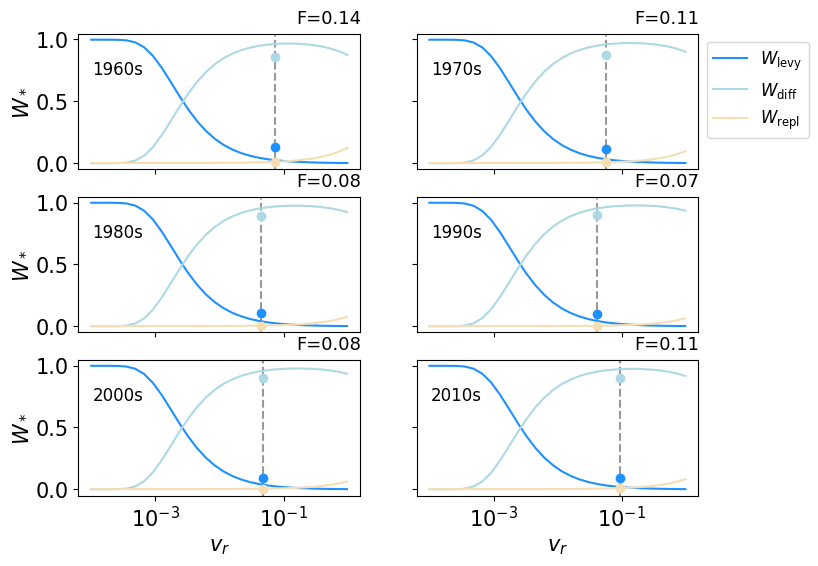

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0
colors = ["dodgerblue", "lightblue", "wheat", "sandybrown"]

for decade in tqdm(range(1960, 2020, 10)):
    open_deriv = decades_data[decade]["o"]
    p0 = decades_data[decade]["p0"]
    pnu = decades_data[decade]["v"]
    ptau = decades_data[decade]["tau"]
    mean_flux = decades_data[decade]["F"]

    pnu_resc = ( pnu - p0 * open_deriv ) / open_deriv
    ptau_resc = ptau / ( p0 * (1 - p0) * open_deriv )

    W_repl = 1 - np.exp( -pnu )
    W_diff = np.exp( -pnu ) * np.exp( -ptau )
    W_levy = np.exp( -pnu ) * ( 1 - np.exp( -ptau ) )

    pnu_resc_vals = np.logspace( -4, np.log10( 1 - p0 ), 30 ) #pick rescaled pnu as variable
    ptau_resc_vals = 1 / pnu_resc_vals #and slide over universal curve

    #model parameters
    pnu_vals = ( pnu_resc_vals + p0 ) * open_deriv
    ptau_vals = ptau_resc_vals * p0 * (1 - p0) * open_deriv

    #regime probabilities (with t=1)
    W_repl_vals = 1 - np.exp( -pnu_vals )
    W_diff_vals = np.exp( -pnu_vals ) * np.exp( -ptau_vals )
    W_levy_vals = np.exp( -pnu_vals ) * ( 1 - np.exp( -ptau_vals ) )

    #regime probabilities (in data)
    handle_data, = axes[row_i, col_i].semilogx( pnu_resc, W_levy, 'o', label=None, c=colors[0], zorder=2 )
    axes[row_i, col_i].semilogx( pnu_resc, W_diff, 'o', label=None, c=colors[1], zorder=2 )
    axes[row_i, col_i].semilogx( pnu_resc, W_repl, 'o', label=None, c=colors[2], zorder=2 )

    #(variable) regime probabilities
    handle_model, = axes[row_i, col_i].semilogx( pnu_resc_vals, W_levy_vals, label='$W_{\mathrm{levy}}$', c=colors[0], zorder=1 )
    axes[row_i, col_i].semilogx( pnu_resc_vals, W_diff_vals, label='$W_{\mathrm{diff}}$', c=colors[1], zorder=1 )
    axes[row_i, col_i].semilogx( pnu_resc_vals, W_repl_vals, label='$W_{\mathrm{repl}}$', c=colors[2], zorder=1 )
    axes[row_i, col_i].text(0.5, 1.1, f"F={round(mean_flux, 2)}", va='bottom', ha='center', fontsize=13)
    if (row_i == 0) and (col_i == 1):
        axes[row_i, col_i].legend(bbox_to_anchor=(1, 1), fontsize=12)

    axes[row_i, col_i].text(0.05, 0.7, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)

    #line at rescaled pnu
    handle_param = axes[row_i, col_i].axvline( pnu_resc, ls='--', c='0.6', label=None, zorder=0 )

    if row_i == 2:
        axes[row_i, col_i].set_xlabel(r'$v_r$')
    if col_i == 0:
        axes[row_i, col_i].set_ylabel(r'$W_*$')
    
    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.savefig("figures/levy_diff_repl_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Number of songs proof

In [6]:
number_of_songs = billboard_hot_100[["artist", "song_name"]].drop_duplicates().groupby("artist")["song_name"].count().reset_index(name="song_count")
billboard_hot_100["number_of_songs"] = billboard_hot_100["artist"].progress_map(lambda artist: number_of_songs[number_of_songs["artist"] == artist]["song_count"].iloc[0])

100%|██████████| 333887/333887 [07:41<00:00, 722.86it/s]


In [7]:
numbers_of_songs = billboard_hot_100[["artist", "number_of_songs"]].drop_duplicates()
count_numbers_of_songs = numbers_of_songs["number_of_songs"].value_counts().sort_index()

In [16]:
numbers_of_songs[numbers_of_songs["number_of_songs"] > 30].sort_values("number_of_songs", ascending=False).to_csv("30_songs_artists.csv")

In [17]:
numbers_of_songs[numbers_of_songs["number_of_songs"] > 30].sort_values("number_of_songs", ascending=False).head(20)

artist  number_of_songs
264990                           Glee Cast              183
251137                        Taylor Swift              163
264978                               Drake              124
308081          YoungBoy Never Broke Again               75
27880                          The Beatles               65
16545                      Aretha Franklin               64
63031                           Elton John               58
29835                   The Rolling Stones               57
236351                          Kanye West               56
30565                        Stevie Wonder               54
18639                       The Beach Boys               54
283205                          The Weeknd               53
280383                              Future               53
130994                             Madonna               53
40827                         Neil Diamond               52
1629                        Connie Francis               51
3318    Elvis Presley With The Jordanaires               51
1634                         Elvis Presley               50
8846                       The Temptations               49
265981                       Justin Bieber               49

In [18]:
top_4_artists = numbers_of_songs[numbers_of_songs["number_of_songs"] > 30].sort_values("number_of_songs", ascending=False).head(4)

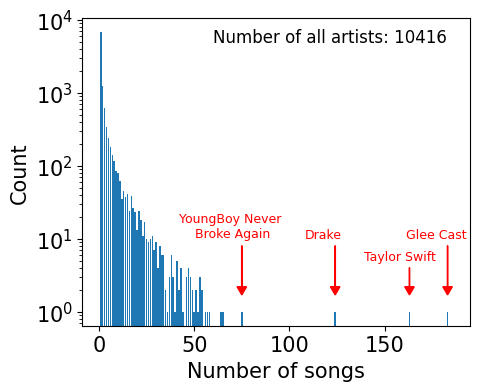

In [32]:
plt.figure(figsize=(5, 4))

plt.bar(count_numbers_of_songs.index, count_numbers_of_songs.values)
nartists = billboard_hot_100["artist"].nunique()
plt.text(60, 5000, f"Number of all artists: {nartists}", fontsize=12)

for i, (_, top_artist)in enumerate(top_4_artists.iterrows()):
    number_of_songs = top_artist["number_of_songs"]
    if i != 1:
        artist_text = top_artist["artist"]
        if len(top_artist["artist"]) > 15:
            artist_text = top_artist["artist"][:15] + "\n" + top_artist["artist"][15:]
            plt.text(number_of_songs - 5, 23, artist_text, fontsize=9, color="red", va="top", ha="center")
        else:
            plt.text(number_of_songs - 6, 14, artist_text, fontsize=9, color="red", va="top", ha="center")
        plt.arrow(number_of_songs, 8, 0, -5.8, width=0.2, head_width=5, head_length=0.5, color="red")
    else:
        plt.arrow(number_of_songs, 4, 0, -1.8, width=0.2, head_width=5, head_length=0.5, color="red")
        plt.text(number_of_songs - 5, 7, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")

plt.xlabel("Number of songs")
plt.ylabel("Count")
plt.yscale("log")
plt.savefig("figures/number_of_songs_per_artist.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Top 10

In [29]:
billboard_hot_100["top_10"] = billboard_hot_100["top_position"] <= 10
number_of_songs_10 = billboard_hot_100[["artist", "song_name", "top_10"]].drop_duplicates().groupby("artist")["top_10"].sum().reset_index(name="top_10_count")

In [30]:
count_numbers_of_songs = number_of_songs_10["top_10_count"].value_counts().sort_index()

In [31]:
number_of_songs_10[number_of_songs_10["top_10_count"] > 5].sort_values("top_10_count", ascending=False).to_csv("top_10_artists.csv")

In [32]:
number_of_songs_10[number_of_songs_10["top_10_count"] > 5].sort_values("top_10_count", ascending=False).head(20)

artist  top_10_count
5702                 Madonna            36
8424            Taylor Swift            35
8570             The Beatles            33
8210           Stevie Wonder            25
6074         Michael Jackson            24
2743              Elton John            23
9296      The Rolling Stones            23
5765            Mariah Carey            22
2528                   Drake            22
10110        Whitney Houston            21
1600                 Chicago            20
4029           Janet Jackson            19
458          Aretha Franklin            16
2132   Daryl Hall John Oates            16
7416                 Rihanna            15
1844          Connie Francis            15
8569          The Beach Boys            15
739                 Bee Gees            15
5859             Marvin Gaye            14
9413            The Supremes            14

In [33]:
top_4_artists = number_of_songs_10[number_of_songs_10["top_10_count"] > 5].sort_values("top_10_count", ascending=False).head(4)

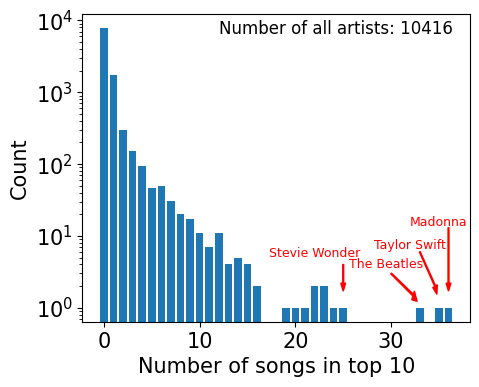

In [34]:
plt.figure(figsize=(5, 4))

plt.bar(count_numbers_of_songs.index, count_numbers_of_songs.values)
nartists = billboard_hot_100["artist"].nunique()
plt.text(12, 6500, f"Number of all artists: {nartists}", fontsize=12)

for i, (_, top_artist)in enumerate(top_4_artists.iterrows()):
    number_of_songs = top_artist["top_10_count"]
    if i == 0:
        plt.arrow(number_of_songs, 13, 0, -10.8, width=0.1, head_width=0.5, head_length=0.5, color="red")
        plt.text(number_of_songs - 1, 19, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")
    elif i == 1:
        plt.arrow(number_of_songs - 2, 6, 1.6, -4, width=0.1, head_width=0.5, head_length=0.5, color="red")
        plt.text(number_of_songs - 3, 9, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")
    elif i == 2:
        plt.arrow(number_of_songs - 3, 3, 2.3, -1.5, width=0.1, head_width=0.5, head_length=0.5, color="red")
        plt.text(number_of_songs - 3.5, 5, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")
    else:
        plt.arrow(number_of_songs, 4, 0, -1.8, width=0.1, head_width=0.5, head_length=0.5, color="red")
        plt.text(number_of_songs - 3, 7, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")

plt.xlabel("Number of songs in top 10")
plt.ylabel("Count")
plt.yscale("log")
plt.savefig("figures/number_of_songs_in_top_10_per_artist.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Paths of hitmakers

In [8]:
artist_song = billboard_hot_100.sort_values(
        "first_day_of_the_week")[["artist", "song_name"]].drop_duplicates()

for i in range(0, 51):
    artist_song[f"{i + 1}th_song"] = artist_song.groupby("artist")["song_name"].transform("nth", i)

In [9]:
billboard_hot_100 = pd.merge(billboard_hot_100, artist_song, on=["artist", "song_name"], how="left")

In [10]:
rows_to_add = []

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]
    
    songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & ~((billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"])))][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week", "year", "top_position"]]
    grouped = songs_in_decade.groupby(["artist", "song_name"])

    min_first_week = songs_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"]
                    })
                    week_date += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "year", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

In [11]:
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0

for th_song in range(1, 7):
    hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] > 10]["artist"]
    hitmakers_th_song = billboard_hot_100[billboard_hot_100["artist"].isin(hitmakers)][f"{th_song}th_song"]

    hitmakers_th_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(hitmakers)) &\
                                                                    billboard_100_with_empty_weeks["song_name"].isin(hitmakers_th_song)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
    
    hitmakers_th_song_trajectories["first_day_of_the_week"] = hitmakers_th_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    hitmakers_th_song_trajectories.set_index("first_day_of_the_week", inplace=True)
    hitmakers_th_song_trajectories.sort_index(inplace=True)
    hitmakers_th_song_trajectories_10 = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] <= 10]
    hitmakers_th_song_trajectories_rest = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] > 10]
    
    hitmakers_th_song_trajectories_10.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.02,
        color="crimson")
    hitmakers_th_song_trajectories_rest.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.02,
        color="C0")
    
    percent_of_top_10 = len(hitmakers_th_song_trajectories_10["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
    percent_of_top_5 = len(hitmakers_th_song_trajectories_10[hitmakers_th_song_trajectories_10["top_position"] <= 5]["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
    percent_of_top_1 = len(hitmakers_th_song_trajectories_10[hitmakers_th_song_trajectories_10["top_position"] == 1]["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
    axes[row_i, col_i].text(0.55, 0.65, f"Top 10: {round(percent_of_top_10, 1)}%", transform=axes[row_i, col_i].transAxes, fontsize=9)
    axes[row_i, col_i].text(0.55, 0.65, f"Top 5: {round(percent_of_top_5, 1)}% Top 1: {round(percent_of_top_1, 1)}%", transform=axes[row_i, col_i].transAxes, fontsize=8)
    axes[row_i, col_i].text(0.75, 0.8, f"{th_song} song", transform=axes[row_i, col_i].transAxes, fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 60])

    if row_i == 0 and col_i == 1:
        custom_lines = [Line2D([0], [0], color="crimson", lw=2),
                Line2D([0], [0], color="C0", lw=2)]
        axes[row_i, col_i].legend(custom_lines, ["Top 10", "Rest"], bbox_to_anchor=(1.05, 1),
                        loc='upper left', borderaxespad=0., fontsize=12)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/hitmakers_1-6th_songs_trajectories.pdf", format="pdf", bbox_inches="tight")
plt.show()

### > 30 songs

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0

for th_song in range(1, 7):
    hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] > 30]["artist"]
    hitmakers_th_song = billboard_hot_100[billboard_hot_100["artist"].isin(hitmakers)][f"{th_song}th_song"]

    hitmakers_th_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(hitmakers)) &\
                                                                    billboard_100_with_empty_weeks["song_name"].isin(hitmakers_th_song)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
    
    hitmakers_th_song_trajectories["first_day_of_the_week"] = hitmakers_th_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    hitmakers_th_song_trajectories.set_index("first_day_of_the_week", inplace=True)
    hitmakers_th_song_trajectories.sort_index(inplace=True)
    hitmakers_th_song_trajectories_10 = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] <= 10]
    hitmakers_th_song_trajectories_rest = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] > 10]
    
    hitmakers_th_song_trajectories_10.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.1,
        color="crimson")
    hitmakers_th_song_trajectories_rest.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.1,
        color="C0")
    
    percent_of_top_10 = len(hitmakers_th_song_trajectories_10["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
    percent_of_top_5 = len(hitmakers_th_song_trajectories_10[hitmakers_th_song_trajectories_10["top_position"] <= 5]["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
    percent_of_top_1 = len(hitmakers_th_song_trajectories_10[hitmakers_th_song_trajectories_10["top_position"] == 1]["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
    axes[row_i, col_i].text(0.58, 0.65, f"Top 10: {round(percent_of_top_10, 1)}%", transform=axes[row_i, col_i].transAxes, fontsize=9)
    axes[row_i, col_i].text(0.65, 0.48, f"Top 5: {round(percent_of_top_5, 1)}%\nTop 1: {round(percent_of_top_1, 1)}%", transform=axes[row_i, col_i].transAxes, fontsize=8)
    th_song = "1st" if th_song == 1 else "2nd" if th_song == 2 else "3rd" if th_song == 3 else f"{th_song}th"
    axes[row_i, col_i].text(0.65, 0.8, f"{th_song} song", transform=axes[row_i, col_i].transAxes, fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 60])

    if row_i == 0 and col_i == 1:
        custom_lines = [Line2D([0], [0], color="crimson", lw=2),
                Line2D([0], [0], color="C0", lw=2)]
        axes[row_i, col_i].legend(custom_lines, ["Top 10", "Rest"], bbox_to_anchor=(1.05, 1),
                        loc='upper left', borderaxespad=0., fontsize=12)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/hitmakers_1-6th_songs_trajectories_30.pdf", format="pdf", bbox_inches="tight")
plt.show()

### 1-6th song of hitmakers vs. the rest (hitmaker > 10 songs)

In [57]:
def plot_first_x_songs(songs, x, ax, color, alpha_x):
    first_x_songs = [g[1] for g in list(songs.groupby(["artist", "song_name"]))[:x]]
    for song in tqdm(first_x_songs):
        song_series = song["position"]
        ax.plot(song_series.index, song_series.values, alpha=alpha_x, color=color)

In [58]:
def plot_th_song_comparison(hitmaker_number, th_song):
    fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharex=True, sharey=True)

    hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] > hitmaker_number]["artist"]
    not_hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] <= hitmaker_number]["artist"]
    hitmakers_1_song = billboard_hot_100[billboard_hot_100["artist"].isin(hitmakers)][f"{th_song}th_song"]
    not_hitmakers_1_song = billboard_hot_100[billboard_hot_100["artist"].isin(not_hitmakers)][f"{th_song}th_song"]

    hitmakers_1_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(hitmakers)) &\
                                                                    billboard_100_with_empty_weeks["song_name"].isin(hitmakers_1_song)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
    hitmakers_1_song_trajectories["first_day_of_the_week"] = hitmakers_1_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    not_hitmakers_1_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(not_hitmakers)) &\
                                                                        billboard_100_with_empty_weeks["song_name"].isin(not_hitmakers_1_song)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
    not_hitmakers_1_song_trajectories["first_day_of_the_week"] = not_hitmakers_1_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    hitmakers_1_song_trajectories.set_index("first_day_of_the_week", inplace=True)
    not_hitmakers_1_song_trajectories.set_index("first_day_of_the_week", inplace=True)
    hitmakers_1_song_trajectories.sort_index(inplace=True)
    not_hitmakers_1_song_trajectories.sort_index(inplace=True)

    hitmakers_1_song_trajectories_10 = hitmakers_1_song_trajectories[hitmakers_1_song_trajectories["top_position"] <= 10]
    hitmakers_1_song_trajectories_rest = hitmakers_1_song_trajectories[hitmakers_1_song_trajectories["top_position"] > 10]
        
    not_hitmakers_1_song_trajectories_10 = not_hitmakers_1_song_trajectories[not_hitmakers_1_song_trajectories["top_position"] <= 10]
    not_hitmakers_1_song_trajectories_rest = not_hitmakers_1_song_trajectories[not_hitmakers_1_song_trajectories["top_position"] > 10]

    no_hitmakers_10_songs = len(hitmakers_1_song_trajectories_10["song_name"].unique())
    no_hitmakers_rest_songs = len(hitmakers_1_song_trajectories_rest["song_name"].unique())

    alpha_x = 0.02 * (hitmaker_number / 10)
    plot_first_x_songs(hitmakers_1_song_trajectories_10, no_hitmakers_10_songs, axes[0, 0], "C0", alpha_x)
    plot_first_x_songs(hitmakers_1_song_trajectories_rest, no_hitmakers_rest_songs, axes[1, 0], "C0", alpha_x)
    plot_first_x_songs(not_hitmakers_1_song_trajectories_10, no_hitmakers_10_songs, axes[0, 1], "C0", alpha_x)
    plot_first_x_songs(not_hitmakers_1_song_trajectories_rest, no_hitmakers_rest_songs, axes[1, 1], "C0", alpha_x)

    axes[0, 0].text(0.55, 0.9, f"Hitmakers", transform=axes[0, 0].transAxes, fontsize=11)
    axes[0, 1].text(0.55, 0.9, f"Not-hitmakers", transform=axes[0, 1].transAxes, fontsize=11)
    axes[0, 0].text(0.55, 0.75, f"Top 10", transform=axes[0, 0].transAxes, fontsize=10)
    axes[0, 1].text(0.55, 0.75, f"Top 10", transform=axes[0, 1].transAxes, fontsize=10)

    axes[1, 0].text(0.55, 0.9, f"Hitmakers", transform=axes[1, 0].transAxes, fontsize=11)
    axes[1, 1].text(0.55, 0.9, f"Not-hitmakers", transform=axes[1, 1].transAxes, fontsize=11)
    axes[1, 0].text(0.55, 0.75, f"Rest", transform=axes[1, 0].transAxes, fontsize=10)
    axes[1, 1].text(0.55, 0.75, f"Rest", transform=axes[1, 1].transAxes, fontsize=10)

    axes[1, 0].set_xlabel("Week")
    axes[1, 1].set_xlabel("Week")
    axes[0, 0].set_ylabel("Position")
    axes[1, 0].set_ylabel("Position")
    axes[0, 0].set_xlim([0, 60])
    axes[0, 1].set_xlim([0, 60])
    axes[1, 0].set_xlim([0, 60])
    axes[1, 1].set_xlim([0, 60])
    
    fig.tight_layout()
    plt.gca().invert_yaxis()
    plt.savefig(f"figures/{th_song}th_songs_hitmakers_{hitmaker_number}_vs_rest.pdf", format="pdf")
    plt.show()

100%|██████████| 408/408 [00:00<00:00, 1306.84it/s]


100%|██████████| 428/428 [00:00<00:00, 1294.50it/s]


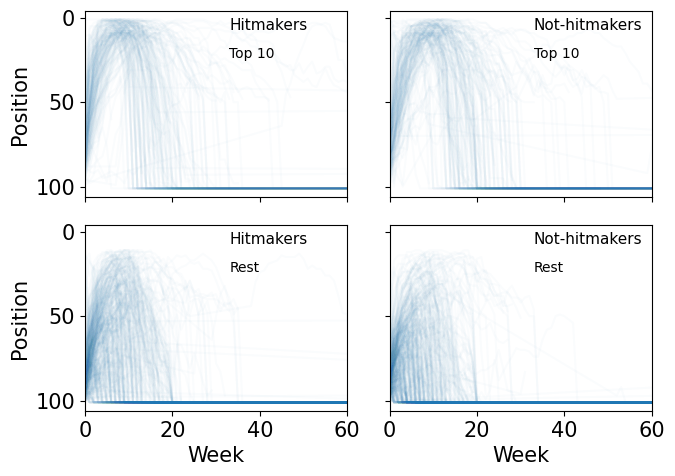

100%|██████████| 410/410 [00:00<00:00, 1802.83it/s]


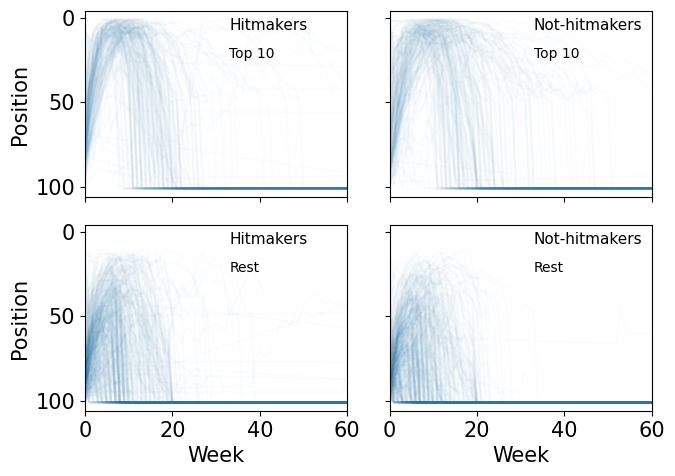

100%|██████████| 432/432 [00:00<00:00, 1074.72it/s]


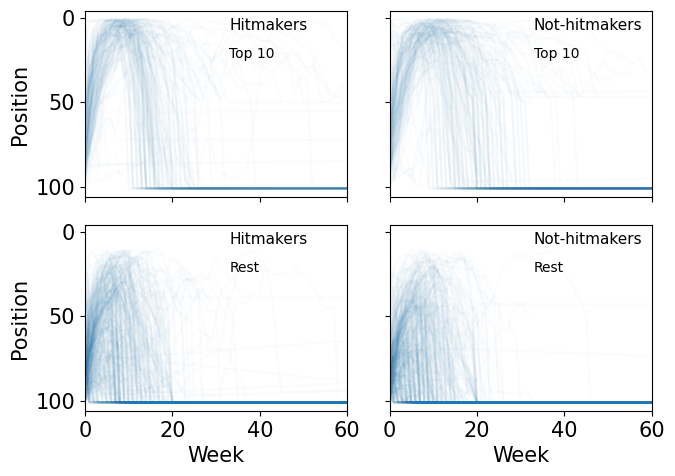

100%|██████████| 420/420 [00:00<00:00, 1173.04it/s]


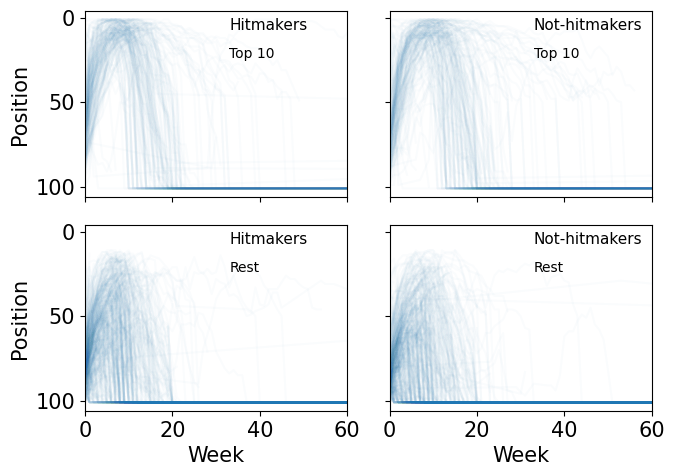

100%|██████████| 428/428 [00:00<00:00, 1308.26it/s]


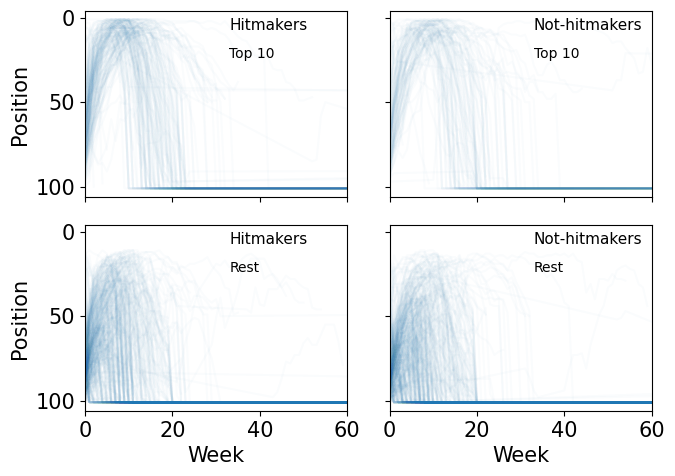

In [59]:
plot_th_song_comparison(10, 1)
plot_th_song_comparison(10, 2)
plot_th_song_comparison(10, 3)
plot_th_song_comparison(10, 4)
plot_th_song_comparison(10, 5)
plot_th_song_comparison(10, 6)

## 1-6th song of hitmaker vs the rest (hitmaker > 30)

100%|██████████| 62/62 [00:00<00:00, 1942.61it/s]


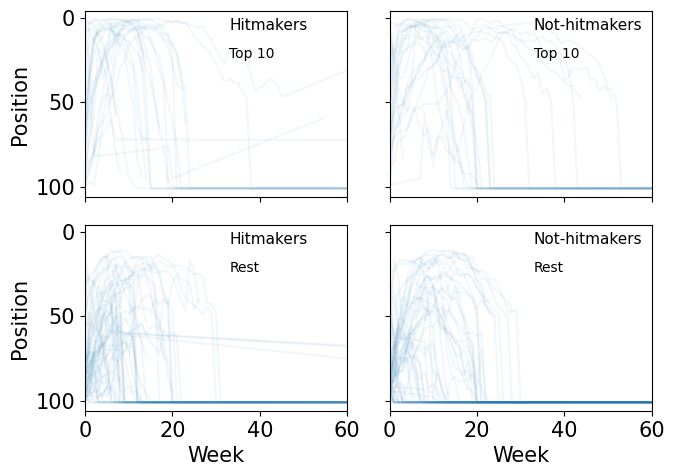

100%|██████████| 66/66 [00:00<00:00, 1696.83it/s]


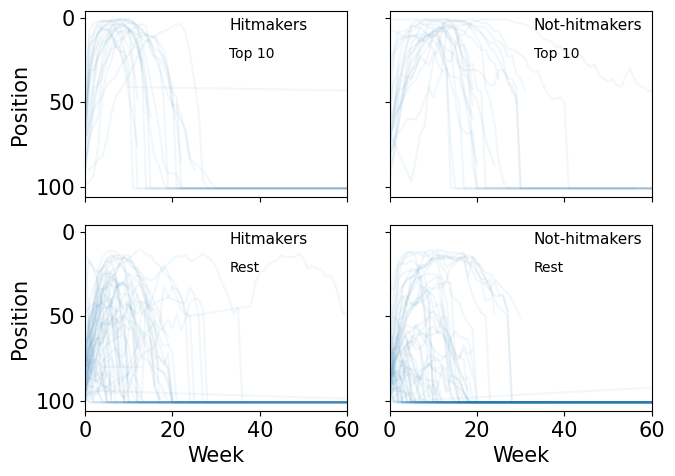

100%|██████████| 62/62 [00:00<00:00, 1322.71it/s]


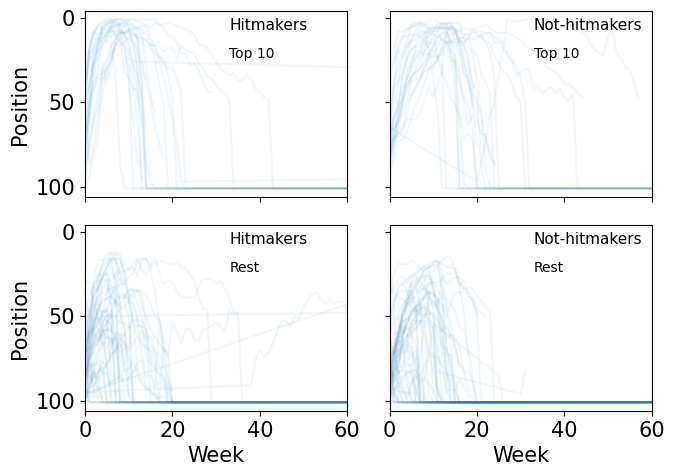

100%|██████████| 64/64 [00:00<00:00, 1833.41it/s]


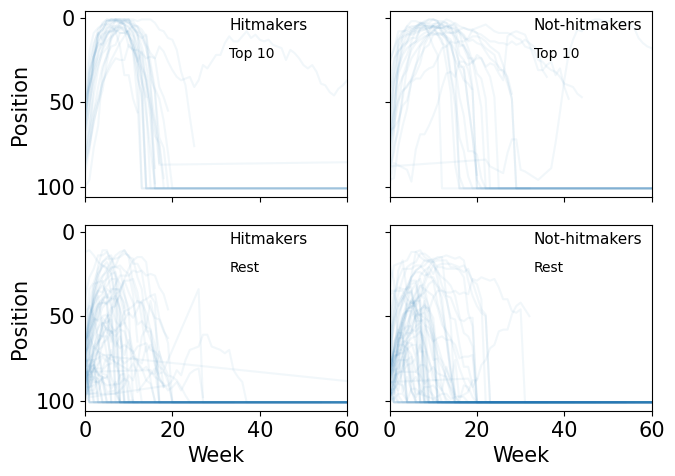

100%|██████████| 65/65 [00:00<00:00, 1863.63it/s]


100%|██████████| 65/65 [00:00<00:00, 1973.38it/s]


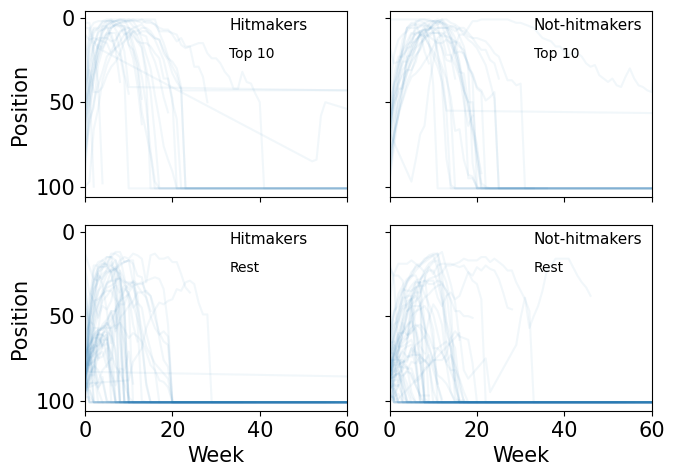

In [60]:
plot_th_song_comparison(30, 1)
plot_th_song_comparison(30, 2)
plot_th_song_comparison(30, 3)
plot_th_song_comparison(30, 4)
plot_th_song_comparison(30, 5)
plot_th_song_comparison(30, 6)

## Hitmakers paths by positions

In [63]:
def plot_th_song_comparison_top_position(hitmaker_number, th_song):
    fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

    row_i, col_i = 0, 0
    positions = [10, 30, 50]
    for i, top_position in enumerate(positions):
        hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] > hitmaker_number]["artist"]
        not_hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] <= hitmaker_number]["artist"]
        hitmakers_1_song = billboard_hot_100[billboard_hot_100["artist"].isin(hitmakers)][f"{th_song}th_song"]
        not_hitmakers_1_song = billboard_hot_100[billboard_hot_100["artist"].isin(not_hitmakers)][f"{th_song}th_song"]

        hitmakers_1_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(hitmakers)) &\
                                                                        billboard_100_with_empty_weeks["song_name"].isin(hitmakers_1_song)][[
            "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
        hitmakers_1_song_trajectories["first_day_of_the_week"] = hitmakers_1_song_trajectories.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

        not_hitmakers_1_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(not_hitmakers)) &\
                                                                            billboard_100_with_empty_weeks["song_name"].isin(not_hitmakers_1_song)][[
            "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
        not_hitmakers_1_song_trajectories["first_day_of_the_week"] = not_hitmakers_1_song_trajectories.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)


        hitmakers_1_song_trajectories.set_index("first_day_of_the_week", inplace=True)
        not_hitmakers_1_song_trajectories.set_index("first_day_of_the_week", inplace=True)
        hitmakers_1_song_trajectories.sort_index(inplace=True)
        not_hitmakers_1_song_trajectories.sort_index(inplace=True)

        if i == 0:
            hitmakers_1_song_trajectories_x = hitmakers_1_song_trajectories[hitmakers_1_song_trajectories["top_position"] <= top_position]
            not_hitmakers_1_song_trajectories_x = not_hitmakers_1_song_trajectories[not_hitmakers_1_song_trajectories["top_position"] <= top_position]
        else:
            hitmakers_1_song_trajectories_x = hitmakers_1_song_trajectories[(hitmakers_1_song_trajectories["top_position"] <= top_position) &\
                                                                            (hitmakers_1_song_trajectories["top_position"] > positions[i-1])]
            not_hitmakers_1_song_trajectories_x = not_hitmakers_1_song_trajectories[(not_hitmakers_1_song_trajectories["top_position"] <= top_position) &\
                                                                            (not_hitmakers_1_song_trajectories["top_position"] > positions[i-1])]
        no_hitmakers_10_songs = len(hitmakers_1_song_trajectories_x["song_name"].unique())

        alpha_x = 2 * 0.02 * (hitmaker_number / 10)
        plot_first_x_songs(hitmakers_1_song_trajectories_x, no_hitmakers_10_songs, axes[row_i, col_i], "C0", alpha_x)
        plot_first_x_songs(not_hitmakers_1_song_trajectories_x, no_hitmakers_10_songs, axes[row_i, col_i + 1], "C0", alpha_x)

        axes[row_i, col_i].text(0.55, 0.85, f"Hitmakers", transform=axes[row_i, col_i].transAxes, fontsize=11)
        axes[row_i, col_i + 1].text(0.55, 0.85, f"Not-hitmakers", transform=axes[row_i, col_i + 1].transAxes, fontsize=11)
        if i == 0:
            axes[row_i, col_i].text(0.65, 0.7, f"Top {top_position - 9}-{top_position}", transform=axes[row_i, col_i].transAxes, fontsize=10)
            axes[row_i, col_i + 1].text(0.65, 0.7, f"Top {top_position - 9}-{top_position}", transform=axes[row_i, col_i + 1].transAxes, fontsize=10)
        else:
            axes[row_i, col_i].text(0.65, 0.75, f"Top {positions[i - 1]}-{top_position}", transform=axes[row_i, col_i].transAxes, fontsize=10)
            axes[row_i, col_i + 1].text(0.65, 0.7, f"Top {positions[i - 1]}-{top_position}", transform=axes[row_i, col_i + 1].transAxes, fontsize=10)

        if row_i == 2:
            axes[row_i, col_i].set_xlabel("Week")
            axes[row_i, col_i + 1].set_xlabel("Week")
        if col_i == 0:
            axes[row_i, col_i].set_ylabel("Position")
        axes[row_i, col_i].set_xlim([0, 60])

        col_i = 0
        row_i += 1

    fig.tight_layout()
    plt.gca().invert_yaxis()
    plt.savefig(f"figures/hitmakers_{th_song}th_songs_trajectories_top_position_{hitmaker_number}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

100%|██████████| 111/111 [00:00<00:00, 1147.40it/s]


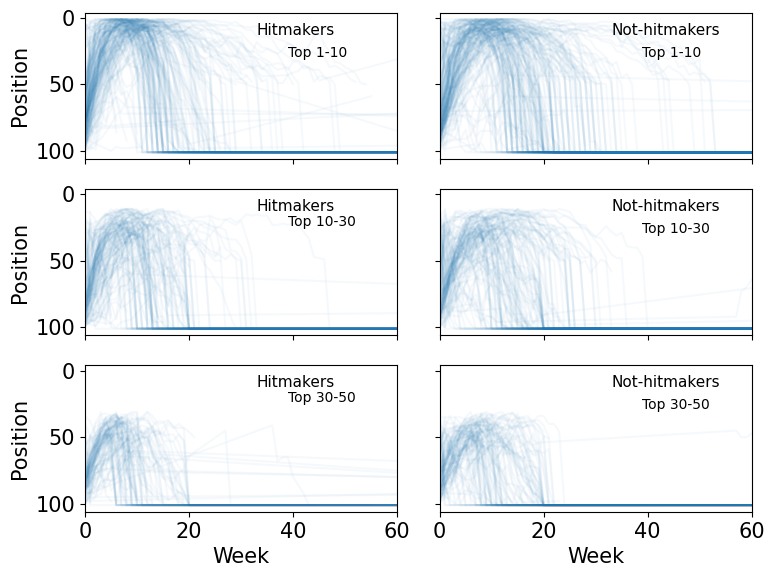

100%|██████████| 128/128 [00:00<00:00, 1565.18it/s]


100%|██████████| 108/108 [00:00<00:00, 1504.01it/s]


100%|██████████| 99/99 [00:00<00:00, 1438.63it/s]


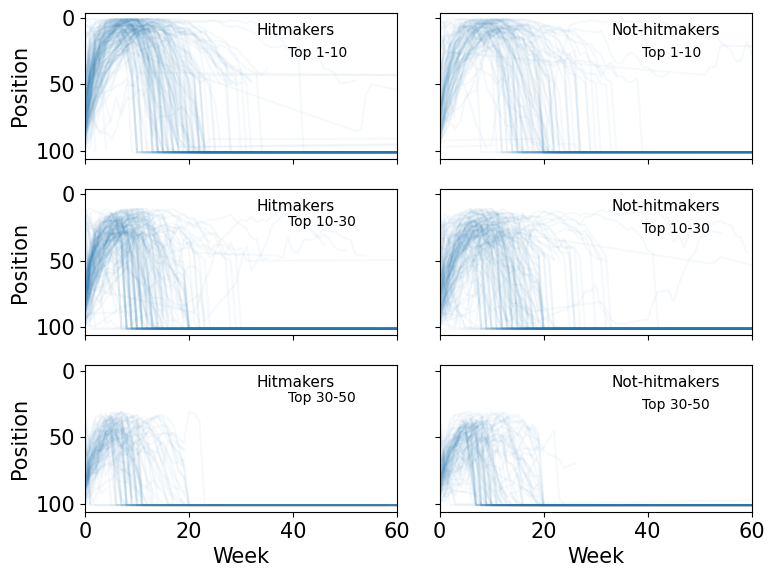

In [64]:
plot_th_song_comparison_top_position(10, 1)
plot_th_song_comparison_top_position(10, 2)
plot_th_song_comparison_top_position(10, 4)
plot_th_song_comparison_top_position(10, 6)

## Hitmakers paths by decade

In [45]:
songs_numbers_count = billboard_hot_100[["year", "artist", "song_name"]].groupby(["year", "artist"])["song_name"].nunique().reset_index(name="number_of_songs")

In [54]:
def plot_th_song_comparison_decades(hitmaker_number, th_song):
    fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

    row_i, col_i = 0, 0

    for decade in range(1960, 2020, 10):
        songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) &\
                                            (billboard_hot_100["year"] < decade + 10)]
        songs_until_decade = songs_numbers_count[songs_numbers_count["year"] < decade + 10].copy()
        songs_until_decade["total_number_of_songs"] = songs_until_decade.groupby(["artist"])["number_of_songs"].transform("sum")
        songs_until_decade = songs_until_decade[(songs_until_decade["year"] >= decade) &\
                                                (songs_until_decade["year"] < decade + 10)]
        
        hitmakers = songs_until_decade[songs_until_decade["total_number_of_songs"] > hitmaker_number]["artist"]
        hitmakers_th_song = songs_from_decade[songs_from_decade["artist"].isin(hitmakers)][f"{th_song}th_song"]

        hitmakers_th_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(hitmakers)) &\
                                                                        billboard_100_with_empty_weeks["song_name"].isin(hitmakers_th_song) &\
                                                                        (billboard_100_with_empty_weeks["year"].isin(songs_from_decade["year"].unique()))][[
            "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
        
        hitmakers_th_song_trajectories["first_day_of_the_week"] = hitmakers_th_song_trajectories.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

        hitmakers_th_song_trajectories.set_index("first_day_of_the_week", inplace=True)

        hitmakers_th_song_trajectories_10 = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] <= 10].copy()
        hitmakers_th_song_trajectories_rest = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] > 10].copy()
        
        hitmakers_th_song_trajectories_10.sort_index(inplace=True)
        hitmakers_th_song_trajectories_rest.sort_index(inplace=True)
        
        hitmakers_th_song_trajectories_10.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.1,
            color="crimson")
        hitmakers_th_song_trajectories_rest.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.1,
            color="C0")
        
        percent_of_top_10 = len(hitmakers_th_song_trajectories_10["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
        percent_of_top_5 = len(hitmakers_th_song_trajectories_10[hitmakers_th_song_trajectories_10["top_position"] <= 5]["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
        percent_of_top_1 = len(hitmakers_th_song_trajectories_10[hitmakers_th_song_trajectories_10["top_position"] == 1]["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
        axes[row_i, col_i].text(0.58, 0.65, f"Top 10: {round(percent_of_top_10, 1)}%", transform=axes[row_i, col_i].transAxes, fontsize=9)
        axes[row_i, col_i].text(0.65, 0.48, f"Top 5: {round(percent_of_top_5, 1)}%\nTop 1: {round(percent_of_top_1, 1)}%", transform=axes[row_i, col_i].transAxes, fontsize=8)
        axes[row_i, col_i].text(0.75, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)

        if row_i == 2:
            axes[row_i, col_i].set_xlabel("Week")
        if col_i == 0:
            axes[row_i, col_i].set_ylabel("Position")
        axes[row_i, col_i].set_xlim([0, 60])

        if row_i == 0 and col_i == 1:
            custom_lines = [Line2D([0], [0], color="crimson", lw=2),
                    Line2D([0], [0], color="C0", lw=2)]
            axes[row_i, col_i].legend(custom_lines, ["Top 10", "Rest"], bbox_to_anchor=(1.05, 1),
                            loc='upper left', borderaxespad=0., fontsize=12)

        col_i += 1
        if col_i == 2:
            col_i = 0
            row_i += 1

    fig.tight_layout()
    plt.gca().invert_yaxis()
    plt.savefig(f"figures/hitmakers_{th_song}th_songs_trajectories_{hitmaker_number}_decades.pdf", format="pdf", bbox_inches="tight")
    plt.show()

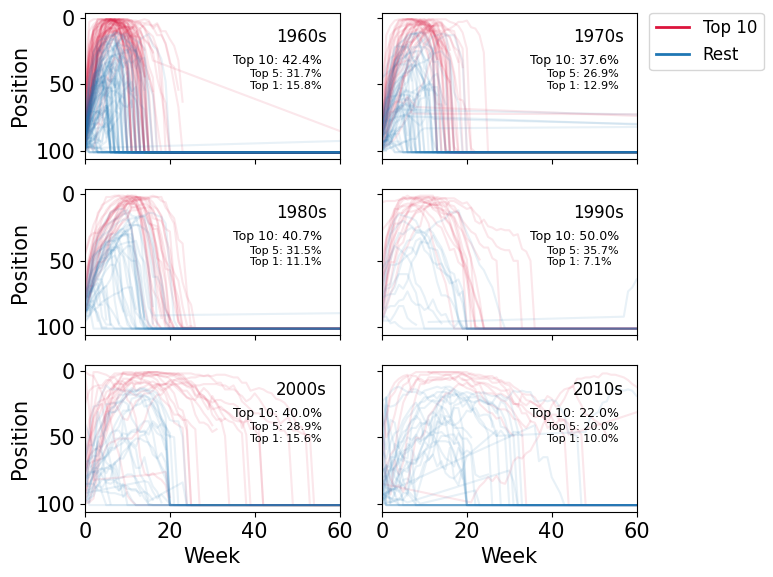

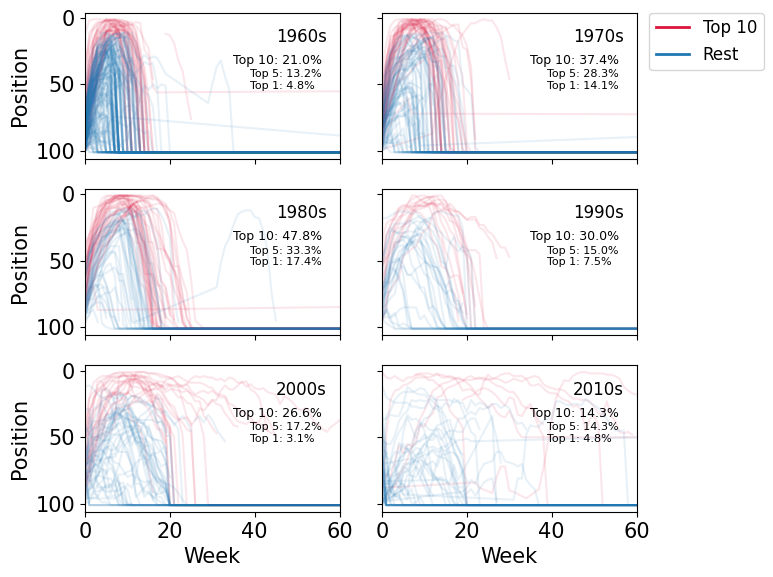

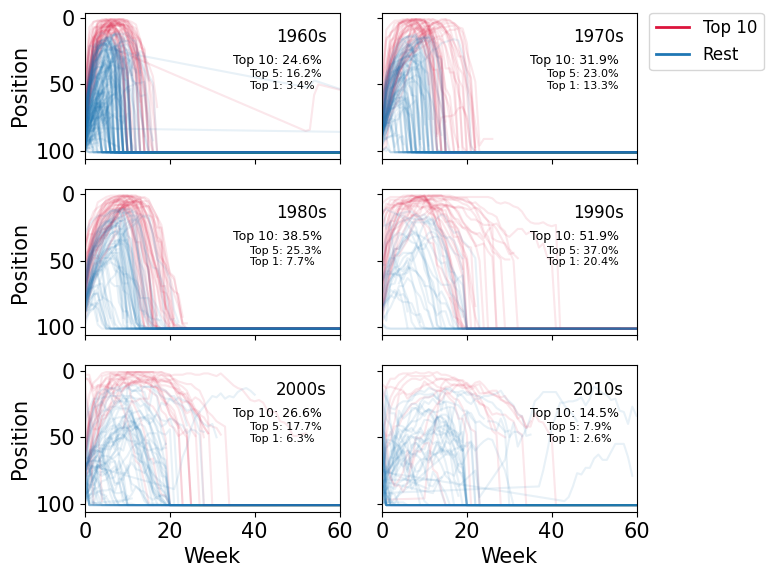

In [55]:
plot_th_song_comparison_decades(10, 1)
plot_th_song_comparison_decades(10, 2)
plot_th_song_comparison_decades(10, 4)
plot_th_song_comparison_decades(10, 6)

## Comparing early carrer with late carrer of artists (1st, 2nd song with last etc)

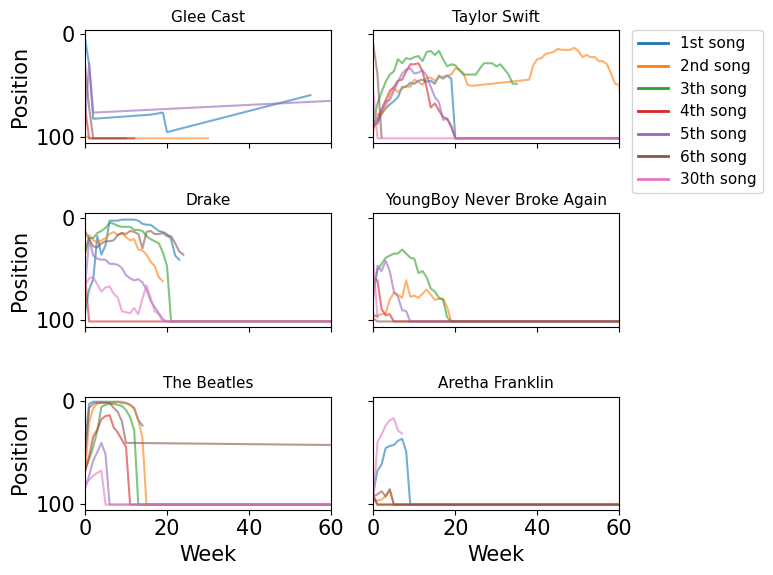

In [78]:
artists_with_most_songs = numbers_of_songs.sort_values("number_of_songs", ascending=False).head(6)["artist"]

fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0
colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6"]

for artist in artists_with_most_songs:
    artist_songs = billboard_hot_100[billboard_hot_100["artist"] == artist]
    artist_1_6_songs = []
    for i in list(range(1, 7)) + [30]:
        i_th_song = artist_songs[f"{i}th_song"].unique()[0]
        artist_1_6_songs.append(i_th_song)

    artist_songs = artist_songs[artist_songs["song_name"].isin(artist_1_6_songs)]["song_name"]

    artist_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"] == artist) &\
                                                                    billboard_100_with_empty_weeks["song_name"].isin(artist_songs)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week"]]
        
    artist_song_trajectories["first_day_of_the_week"] = artist_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    for song_name, color in zip(artist_1_6_songs, colors):
        song = artist_song_trajectories[artist_song_trajectories["song_name"] == song_name].copy()
        song.set_index("first_day_of_the_week", inplace=True)
        song.sort_index(inplace=True)
        song_series = song["position"]
        axes[row_i, col_i].plot(song_series.index, song_series.values, alpha=0.6, color=color)
    axes[row_i, col_i].set_title(f"{artist}", fontsize=11)

    if row_i == 0 and col_i == 1:
        custom_lines = [Line2D([0], [0], color=color_i, lw=2) for color_i in colors]
        song_placements = ["1st song", "2nd song"] + [f"{i}th song" for i in list(range(3, 7)) + [30]]
        axes[row_i, col_i].legend(custom_lines, song_placements, bbox_to_anchor=(1.05, 1),
                        loc='upper left', borderaxespad=0., fontsize=11)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 60])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig(f"figures/hitmakers_songs_trajectories_most_songs.pdf", format="pdf", bbox_inches="tight")
plt.show()

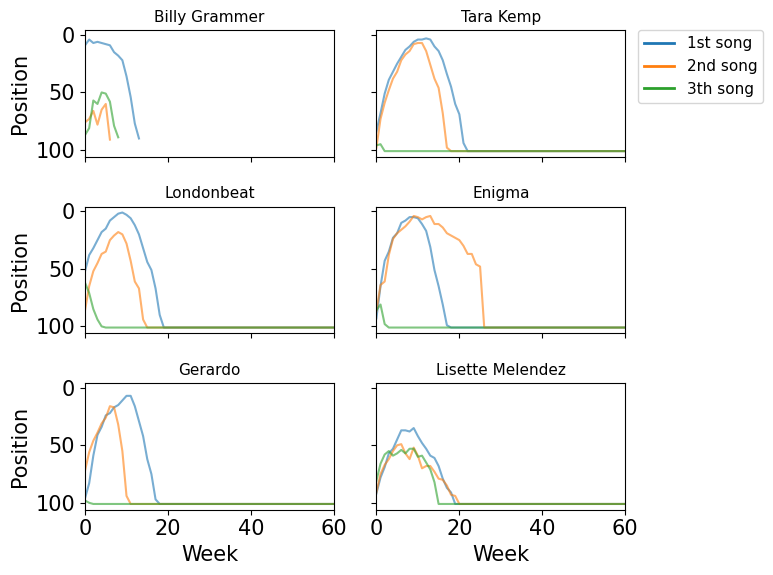

In [76]:
# compare by one artist take 6 artists with most songs and 6 with least
artists_with_most_songs = numbers_of_songs[numbers_of_songs["number_of_songs"] == 3].sort_values("number_of_songs", ascending=True).head(6)["artist"]

fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0
colors = ["C0", "C1", "C2", "C3", "C4", "C5"]

for artist in artists_with_most_songs:
    artist_songs = billboard_hot_100[billboard_hot_100["artist"] == artist]
    artist_1_6_songs = []
    for i in range (1, 4):
        i_th_song = artist_songs[f"{i}th_song"].unique()[0]
        artist_1_6_songs.append(i_th_song)

    artist_songs = artist_songs[artist_songs["song_name"].isin(artist_1_6_songs)]["song_name"]

    artist_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"] == artist) &\
                                                                    billboard_100_with_empty_weeks["song_name"].isin(artist_songs)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week"]]
        
    artist_song_trajectories["first_day_of_the_week"] = artist_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    for song_name, color in zip(artist_1_6_songs, colors):
        song = artist_song_trajectories[artist_song_trajectories["song_name"] == song_name].copy()
        song.set_index("first_day_of_the_week", inplace=True)
        song.sort_index(inplace=True)
        song_series = song["position"]
        axes[row_i, col_i].plot(song_series.index, song_series.values, alpha=0.6, color=color)
    axes[row_i, col_i].set_title(f"{artist}", fontsize=11)

    if row_i == 0 and col_i == 1:
        custom_lines = [Line2D([0], [0], color=color_i, lw=2) for color_i in colors]
        song_placements = ["1st song", "2nd song"] + [f"{i}th song" for i in range(3, 4)]
        axes[row_i, col_i].legend(custom_lines, song_placements, bbox_to_anchor=(1.05, 1),
                        loc='upper left', borderaxespad=0., fontsize=11)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 60])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig(f"figures/hitmakers_songs_trajectories_least_songs.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Number of songs vs top position of 1st, 2nd... song

In [85]:
billboard_hot_100[billboard_hot_100["song_name"] == billboard_hot_100["1th_song"]][["artist", "song_name", "top_position"]].drop_duplicates()

artist                    song_name  \
0          The Chipmunks With David Seville            The Chipmunk Song   
2                              The Platters      Smoke Gets In Your Eyes   
3                            Connie Francis                 My Happiness   
4                             Billy Grammer              Gotta Travel On   
5                           The Teddy Bears  To Know Him, Is To Love Him   
...                                     ...                          ...   
333586             RAYE Featuring 070 Shake                     Escapism   
333656            SZA Featuring Don Toliver                         Used   
333661        SZA Featuring Phoebe Bridgers         Ghost In The Machine   
333679  Pentatonix Featuring Meghan Trainor             Kid On Christmas   
333762      SZA Featuring Ol' Dirty Bastard                  Forgiveless   

        top_position  
0                  1  
2                  1  
3                  2  
4                  4  
5                  3  
...              ...  
333586            72  
333656            30  
333661            40  
333679            93  
333762            76  

[10416 rows x 3 columns]

artist  song_count
0                                        "Groove" Holmes           2
1                                 "Little" Jimmy Dickens           1
2                                        "Pookie" Hudson           1
3                                    "Weird Al" Yankovic          11
4                                      $NOT & A$AP Rocky           1
...                                                  ...         ...
10411                            will.i.am & Nicki Minaj           1
10412                  will.i.am Featuring Justin Bieber           1
10413   will.i.am Featuring Mick Jagger & Jennifer Lopez           1
10414                    will.i.am Featuring Miley Cyrus           1
10415  will.i.am Featuring Miley Cyrus, French Montan...           1

[10416 rows x 2 columns]

In [94]:
# number of songs vs top position of 1th song
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

first_song_top_position = billboard_hot_100[billboard_hot_100["song_name"] == billboard_hot_100["1th_song"]][["artist", "song_name", "top_position"]].drop_duplicates().copy()
first_song_top_position["number_of_songs"] = first_song_top_position["artist"].progress_map(lambda artist: number_of_songs[number_of_songs["artist"] == artist]["song_count"].iloc[0])

ax.scatter(first_song_top_position["number_of_songs"], first_song_top_position["top_position"], alpha=0.6)
ax.set_xlabel("Number of songs")
ax.set_ylabel("Position of 1st song")

plt.gca().invert_yaxis()
plt.savefig(f"figures/hitmakers_number_of_songs_vs_1th_song_position.pdf", format="pdf", bbox_inches="tight")
plt.show()

100%|██████████| 10416/10416 [00:15<00:00, 668.09it/s]


In [95]:
# number of songs vs top position of 1th song
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

first_song_top_position = billboard_hot_100[billboard_hot_100["song_name"] == billboard_hot_100["2th_song"]][["artist", "song_name", "top_position"]].drop_duplicates().copy()
first_song_top_position["number_of_songs"] = first_song_top_position["artist"].progress_map(lambda artist: number_of_songs[number_of_songs["artist"] == artist]["song_count"].iloc[0])

ax.scatter(first_song_top_position["number_of_songs"], first_song_top_position["top_position"], alpha=0.6)
ax.set_xlabel("Number of songs")
ax.set_ylabel("Position of 2nd song")

plt.gca().invert_yaxis()
plt.savefig(f"figures/hitmakers_number_of_songs_vs_2th_song_position.pdf", format="pdf", bbox_inches="tight")
plt.show()

100%|██████████| 3587/3587 [00:06<00:00, 581.64it/s]


100%|██████████| 632/632 [00:01<00:00, 571.41it/s]


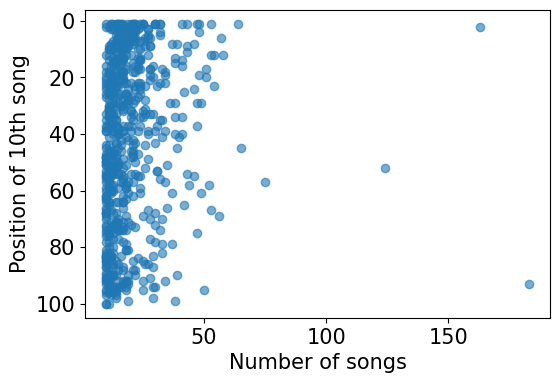

In [96]:
# number of songs vs top position of 1th song
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

first_song_top_position = billboard_hot_100[billboard_hot_100["song_name"] == billboard_hot_100["10th_song"]][["artist", "song_name", "top_position"]].drop_duplicates().copy()
first_song_top_position["number_of_songs"] = first_song_top_position["artist"].progress_map(lambda artist: number_of_songs[number_of_songs["artist"] == artist]["song_count"].iloc[0])

ax.scatter(first_song_top_position["number_of_songs"], first_song_top_position["top_position"], alpha=0.6)
ax.set_xlabel("Number of songs")
ax.set_ylabel("Position of 10th song")

plt.gca().invert_yaxis()
plt.savefig(f"figures/hitmakers_number_of_songs_vs_10th_song_position.pdf", format="pdf", bbox_inches="tight")
plt.show()